# Bank Customers' churn prediction

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff

In [69]:
data = pd.read_csv("data.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [70]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [71]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [72]:
type_ = ["Churn", "No Churn"]
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Pie(labels=type_, values=data['Exited'].value_counts(), name="Exited"))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Churn Distributions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Churn', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [73]:
# Convert all columns heading in lowercase 
clean_column_name = []
columns = data.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
data.columns = clean_column_name

In [74]:
training_data = data.drop(["rownumber", "customerid", "surname"], axis = 1)

In [75]:
training_data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [76]:
target_columns = ["exited"]
cat_columns   = training_data.nunique()[training_data.nunique() < 6].keys().tolist()
cat_columns   = [x for x in cat_columns if x not in target_columns]
num_columns   = [x for x in training_data.columns if x not in cat_columns + target_columns]

churn     = training_data[training_data["exited"] == 1]
not_churn = training_data[training_data["exited"] == 0]


In [77]:
cat_columns

['geography', 'gender', 'numofproducts', 'hascrcard', 'isactivemember']

In [78]:
num_columns

['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']

Categorical variable EDA

In [79]:
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

In [80]:
plot_pie(cat_columns[0])

In [81]:
plot_pie(cat_columns[1])

In [82]:
plot_pie(cat_columns[2])

In [83]:
plot_pie(cat_columns[3])

In [84]:
plot_pie(cat_columns[4])

In [85]:
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

In [86]:
histogram(num_columns[0])

In [87]:
histogram(num_columns[1])

In [88]:
histogram(num_columns[2])

In [89]:
histogram(num_columns[3])

In [90]:
histogram(num_columns[4])

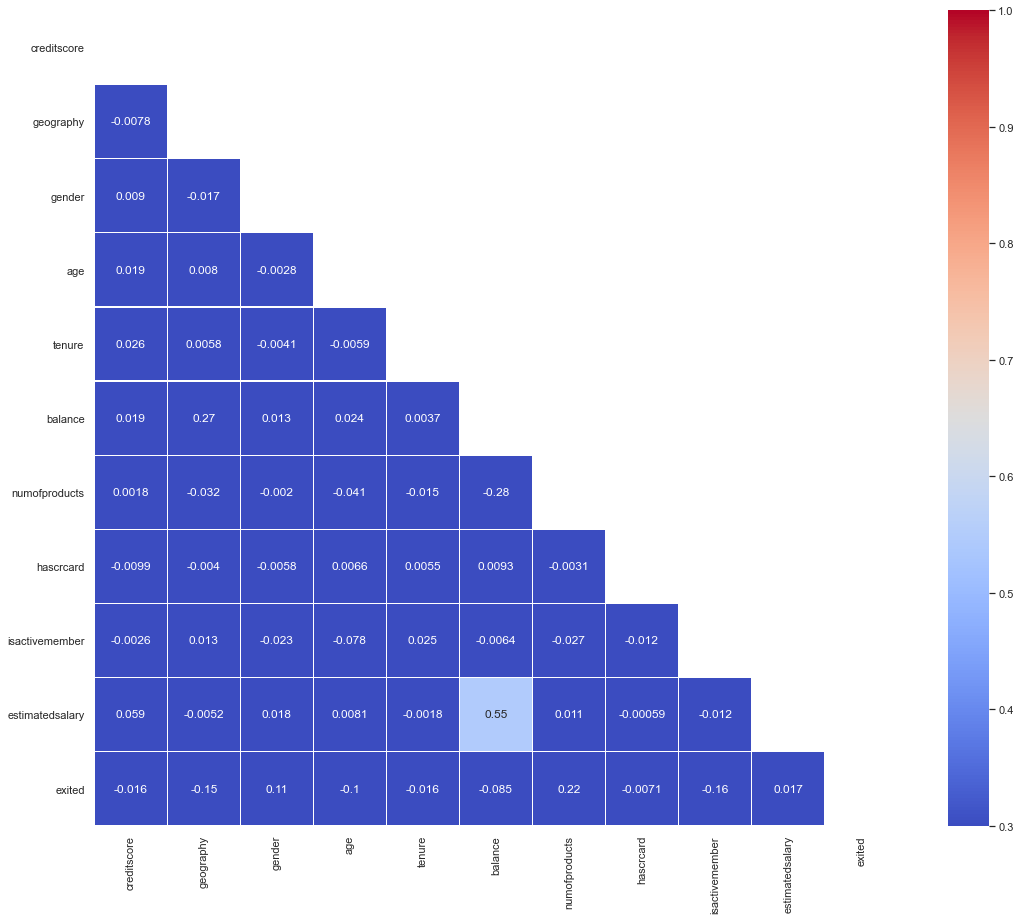

In [91]:
sns.set(style="white")
plt.figure(figsize=(18, 15))

corr = training_data.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=0.3, vmax=1)

In [92]:

def box_plot(df):
    for feature in df:
        trace.append(go.Box(name = feature, y = df[feature]))
trace = []
        
new_df = training_data[num_columns[:1]]
box_plot(new_df)
data_ = trace
py.iplot(data_)



In [93]:
trace = []
new_df1 = training_data[num_columns[1:3]]
box_plot(new_df1)
data_1 = trace
py.iplot(data_1)

In [94]:
trace = []
new_df2 = training_data[num_columns[-1:]]
box_plot(new_df2)
data_2 = trace
py.iplot(data_2)

In [95]:
# handeling Outliers

In [96]:
# One-Hot encoding 
variables = ['geography', 'gender']
training_data = pd.get_dummies(training_data, columns = variables, prefix = variables)

In [97]:
training_data.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


### Baseline Model
Feature engineering for the baseline model

In [111]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [103]:

y= training_data.exited
X = training_data.drop(["exited"], axis= 1)
features_labels = X.columns
RF = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
RF.fit(X,y)
features_imp = RF.feature_importances_


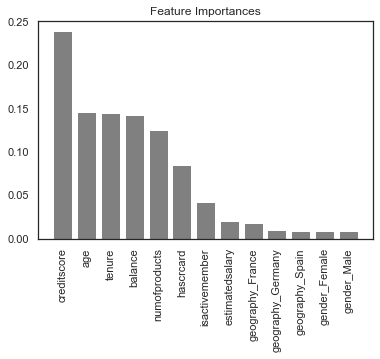

 1) creditscore                    0.239072
 2) age                            0.146101
 3) tenure                         0.144845
 4) balance                        0.142333
 5) numofproducts                  0.125054
 6) hascrcard                      0.085224
 7) isactivemember                 0.042107
 8) estimatedsalary                0.020549
 9) geography_France               0.017904
10) geography_Germany              0.010410
11) geography_Spain                0.009040
12) gender_Female                  0.008845
13) gender_Male                    0.008514


In [109]:
indices = np.argsort(features_imp)[::-1]
    
# Visualization
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), features_imp[indices], color = "grey", align = "center")
plt.xticks(range(X.shape[1]), features_labels, rotation = 90)
plt.show()

for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_labels[i], features_imp[indices[i]]))
    


In [112]:
#Building the baseline models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)

In [115]:
models = []
models.append(("KNN", KNeighborsClassifier(n_neighbors=5, metric = "minkowski", weights= "uniform", p=2, leaf_size = 30, algorithm= "auto", metric_params =None)))
models.append(("Logistic Regression", LogisticRegression(penalty = 'l2', dual = False, tol = 0.0001, C = 1.0, fit_intercept = True,
                            intercept_scaling = 1, class_weight = None, 
                            random_state = None, solver = 'liblinear', max_iter = 100,
                            multi_class = 'ovr', verbose = 2)))
models.append(("Adaboost", AdaBoostClassifier(base_estimator = None, n_estimators = 200, learning_rate = 1.0)))
models.append(("GradientBoost", GradientBoostingClassifier(loss = 'deviance', n_estimators = 200)))
models.append(("RandomForest", RandomForestClassifier(n_estimators=10, criterion='gini')))

In [183]:
names = []
acc_results = []
test_labels = []
roc_auc_results = []
models_fit = []
for name, model in models:
    print(name)
    names.append(name)
    model_ = model.fit(X_train,y_train)
    models_fit.append(model_)
    
    acc = model_.score(X_test, y_test)
    acc_results.append(acc)
    
    test_ = model_.predict_proba(np.array(X_test))
    test_ = test_[:, 1]
    test_labels.append(test_)
    
    roc_auc = roc_auc_score(y_test, test_, multi_class='ovo', average='weighted')
    roc_auc_results.append(roc_auc)
    
    

KNN
Logistic Regression
[LibLinear]Adaboost
GradientBoost
RandomForest


In [184]:
list_ = list(zip(names, acc_results, roc_auc_results))
model_results_df = pd.DataFrame(list_,
                  columns = ['Model', 'Accuracy', "ROC_AUC"])

In [185]:
model_results_df.sort_values(by = "Accuracy", ascending=False)

,Model,Accuracy,ROC_AUC
3,GradientBoost,0.8724,0.877790
2,Adaboost,0.8580,0.857243
4,RandomForest,0.8508,0.835957
1,Logistic Regression,0.7864,0.676092
0,KNN,0.7572,0.527396


In [186]:
fpr_knn, tpr_knn, _ = roc_curve(y_test, test_labels[0])
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_labels[1])
fpr_ada, tpr_ada, _ = roc_curve(y_test, test_labels[2])
fpr_gb, tpr_gb, _ = roc_curve(y_test, test_labels[3])
fpr_rf, tpr_rf, _ = roc_curve(y_test, test_labels[4])

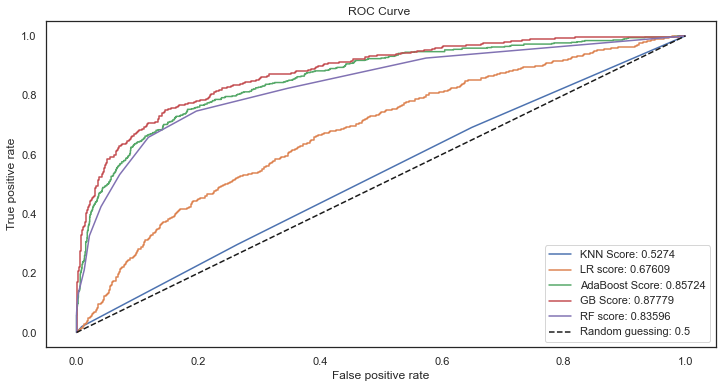

In [187]:
# Plot the roc curve
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_knn, tpr_knn, label = 'KNN Score: ' + str(round(roc_auc_results[0], 5)))
plt.plot(fpr_lr, tpr_lr, label = 'LR score: ' + str(round(roc_auc_results[1], 5)))
plt.plot(fpr_ada, tpr_ada, label = 'AdaBoost Score: ' + str(round(roc_auc_results[2], 5)))
plt.plot(fpr_gb, tpr_gb, label = 'GB Score: ' + str(round(roc_auc_results[3], 5)))
plt.plot(fpr_rf, tpr_rf, label = 'RF score: ' + str(round(roc_auc_results[4], 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random guessing: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve ')
plt.legend(loc='best')
plt.show()


## Optimization

In [200]:
# Import the cross-validation module
from sklearn.model_selection import cross_val_score

# Function that will track the mean value and the standard deviation of the accuracy
def CrossValidationDict(models_list, scr, X_train = X, y_train = y, cv = 5):
    cvDict = {}
    for mo in models_list:
        cvScore = cross_val_score(mo, X_train, y_train, cv = cv, scoring = scr)
        
        cvDict[str(mo).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

In [201]:
CrossValidationDict(models_fit, scr = 'roc_auc')

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

{'KNeighborsClassifier': [0.532941795209413, 0.015143901787688084],
 'LogisticRegression': [0.6760685005593966, 0.008566362985053123],
 'AdaBoostClassifier': [0.8441075841841352, 0.004784942283619017],
 'GradientBoostingClassifier': [0.8643617683814853, 0.005197300407340902],
 'RandomForestClassifier': [0.8208921350104272, 0.008784500468906078]}

Based on the mean value and the standard deviation value, we can conclude that our ROC-AUC score does not deviate much, so we are not suffering from the overfitting issue.

## Hyperparameter Tuning

In [198]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

## Adaboost

In [313]:

parameters_list = {"algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" :[10,50,100,200,400]}


In [314]:
GSA = RandomizedSearchCV(AdaBoostClassifier(), param_distributions=parameters_list, n_iter=10, scoring = "roc_auc")
GSA.fit(X_train, y_train)

RandomizedSearchCV(estimator=AdaBoostClassifier(),
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'n_estimators': [10, 50, 100, 200,
                                                         400]},
                   scoring='roc_auc')

In [315]:
GSA.best_params_, GSA.best_score_

({'n_estimators': 200, 'algorithm': 'SAMME'}, 0.8432902741161931)

## Gradientboost

In [316]:
gb_parameters_list = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

GBM = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=gb_parameters_list, n_iter=10, scoring="roc_auc")
GBM.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                   param_distributions={'loss': ['deviance', 'exponential'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025BEECC3D30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025C4335A8B0>},
                   scoring='roc_auc')

In [317]:
GBM.best_params_, GBM.best_score_

({'loss': 'exponential', 'max_depth': 3, 'n_estimators': 241},
 0.8576619853133595)

## Training the models with new HyperParameters

In [318]:
# Adaboost
GSA_fit = GSA.best_estimator_.fit(X_train, y_train)

#gradientboost
GBM_fit = GBM.best_estimator_.fit(X_train, y_train)

In [319]:
#Crossvalidation
functions = [GSA_fit, GBM_fit]
cross_validate = CrossValidationDict(functions, scr="roc_auc")
cross_validate

{'AdaBoostClassifier': [0.8442783055508478, 0.005744140217744953],
 'GradientBoostingClassifier': [0.864696050465407, 0.0046057936997600454]}

In [320]:
#Adaboost
test_1 = GSA_fit.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_1 , average = 'macro', sample_weight = None)


0.8563846740588049

In [321]:
# Gradientboost
test_2 = GBM_fit.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_2 , average = 'macro', sample_weight = None)

0.8778101653906232

## Feature Transformation

In [323]:
from sklearn.preprocessing import StandardScaler

In [324]:
X_train_ = np.array(X_train)
scaler = StandardScaler()

# For the test set
X_test_ = np.array(X_test)

X_train_transform = scaler.fit_transform(X_train_)
X_test_transform = scaler.fit_transform(X_test_)

In [325]:
# Adaboost
GSA_fit_transformed = GSA.best_estimator_.fit(X_train_transform, y_train)

#gradientboost
GBM_fit_transformed= GBM.best_estimator_.fit(X_train_transform, y_train)

In [326]:
#Crossvalidation
functions_ = [GSA_fit_transformed, GBM_fit_transformed]
cross_validate_ = CrossValidationDict(functions_, scr="roc_auc")
cross_validate_

{'AdaBoostClassifier': [0.8442783055508478, 0.005744140217744953],
 'GradientBoostingClassifier': [0.8649537238655876, 0.004446308069632222]}

In [327]:
#Gradient boost
test_labels = GBM_fit_transformed.predict_proba(np.array(X_test_transform))[:,1]
roc_auc_score(y_test,test_labels , average = 'macro', sample_weight = None)

0.873749653401012

## Voting Classifier

In [328]:
from sklearn.ensemble import VotingClassifier

In [329]:
voting_model = VotingClassifier(estimators=[("gb", GBM_fit_transformed), 
                                            ("ADA", GSA_fit_transformed)],
                                voting = 'soft', weights = [2,1])

                                    
# Fitting the model
votingModel = voting_model.fit(X_train_transform, y_train)

In [330]:
test_labels_voting = votingModel.predict_proba(np.array(X_test_transform))[:,1]
votingModel.score(X_test_transform, y_test)

0.8732

In [331]:
roc_auc_score(y_test,test_labels_voting, average = 'macro', sample_weight = None)

0.8744660402064695

### On untransformed data

In [332]:
voting_model_ = VotingClassifier(estimators=[("gb", GBM_fit), 
                                            ("ADA", GSA_fit)],
                                voting = 'soft', weights = [2,1])

                                    
# Fitting the model
votingModel_ = voting_model_.fit(X_train, y_train)

In [333]:
test_labels_voting_ = votingModel_.predict_proba(np.array(X_test))[:,1]
votingModel_.score(X_test, y_test)

0.8732

In [334]:
roc_auc_score(y_test,test_labels_voting_, average = 'macro', sample_weight = None)

0.8774529587465796

With Transformed and un-transformed data, both the models are giving accuracy more than 87%